In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
# from osmnx. import plot_graph_route_folium


In [22]:
import osmnx as ox
print(ox.__version__)


2.0.4


In [ ]:
city = "Eldon"  # change to any city from Walmart dataset like "Conway"
dtf = pd.read_csv('walmart.csv')  # use correct filename here

# fix column names to match Walmart dataset
dtf = dtf[dtf["city"] == city][["city", "street_address", "latitude", "longitude"]].reset_index(drop=True)

# rename for internal processing
dtf = dtf.reset_index().rename(columns={"index": "id", "latitude": "y", "longitude": "x"})

print("total", len(dtf))
dtf.head(3)


total 0


,id,city,street_address,y,x


In [24]:
# color markers
data = dtf.copy()
data["color"] = ''
data.loc[data['id'] == 0, 'color'] = 'red'
data.loc[data['id'] != 0, 'color'] = 'black'

# starting point
# Use the first row as the starting point
start = data.loc[0, ["y", "x"]].values
print("starting point:", start)



KeyError: 0

In [ ]:
# render map
import folium
map = folium.Map(location=start, tiles="CartoDB positron", zoom_start=12)
data.apply(lambda row:
    folium.CircleMarker(
        location=[row["y"], row["x"]],
        color=row["color"], fill=True, radius=5).add_to(map), axis=1)

map

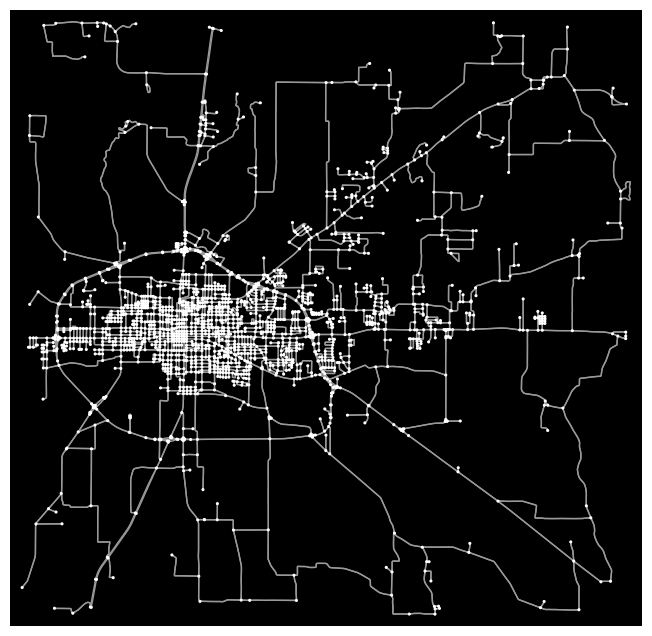

In [ ]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5, node_color="white", figsize=(16,8))

In [ ]:

start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf.head()

C:\Users\Dell-Laptop\AppData\Local\Temp\ipykernel_6040\541981123.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
C:\Users\Dell-Laptop\AppData\Local\Temp\ipykernel_6040\541981123.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
C:\Users\Dell-Laptop\AppData\Local\Temp\ipykernel_6040\541981123.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

,id,city,street_address,y,x,node
0,0,Paris,3855 Lamar Ave,33.664699,-95.505897,233800660
1,1,Paris,1210 Mineral Wells Ave,36.281103,-88.307919,233795301
2,2,Paris,1501 E Walnut St,35.293369,-93.716195,233792511


In [ ]:
def f(a, b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d
distance_matrix = np.asarray([[f(a, b)for b in dtf["node"].tolist()]for a in dtf["node"].tolist()])
distance_matrix = pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

,233800660,233795301,233792511
233800660,0.000000,598.051146,568.499094
233795301,626.064731,0.000000,146.105994
233792511,596.512679,146.105994,0.000000


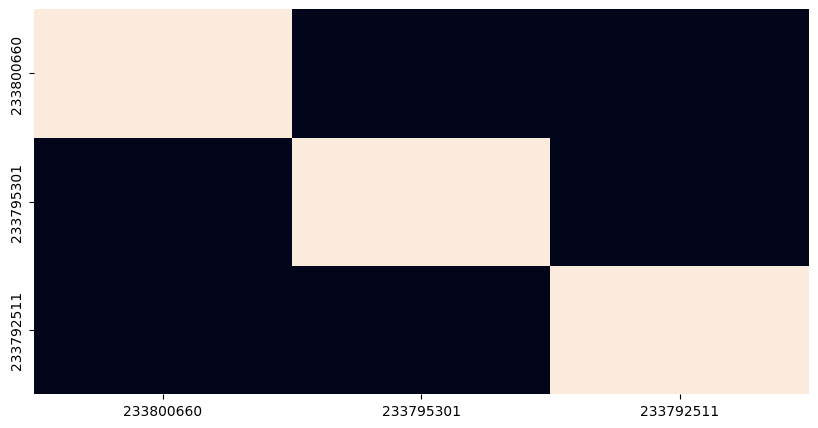

In [ ]:
heatmap = distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x:
        0.3 if pd.isnull(x) else
        (0.7 if np.isinf(x) else
         (0 if x!=0 else 1)))
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(heatmap, vmin=0, vmax=1, cbar=False, ax=ax)
plt.show()

In [ ]:
distance_matrix =  distance_matrix.round()
distance_matrix.replace([np.nan, np.inf], 999999, inplace=True)
distance_matrix = distance_matrix.astype('int')
distance_matrix

,233800660,233795301,233792511
233800660,0,598,568
233795301,626,0,146
233792511,597,146,0


In [ ]:
drivers = 1
lst_nodes = dtf["node"].tolist()
print("start: ", start_node, ", total locations to visit: ", len(lst_nodes)-1, ", drivers: ", drivers)


start:  233800660 , total locations to visit:  2 , drivers:  1


In [ ]:
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model = pywrapcp.RoutingModel(manager)

In [ ]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance = model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [ ]:
solution=model.SolveWithParameters(parameters)
index = model.Start(0)
print('route for drivers: ')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index = index
    index=solution.Value(model.NextVar(index))
    
    try:
        route_distance += get_distance(previous_index, index)
    except:
        route_distance+= model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f'Total distance: {round(route_distance/1000, 2)}KM')
print(f'Nodes visited: {len(route_idx)}')

route for drivers: 
[0, 1, 2]
Total distance: 0.74KM
Nodes visited: 3


In [ ]:
print("Route for driver (nodes): ")
lst_route = [lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes): 
[233800660, 233795301, 233792511]


In [ ]:
def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

for path in lst_paths:
    route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
    folium.PolyLine(route_coords, color="blue", weight=2, opacity=0.8).add_to(map)
    
map

In [ ]:

def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], [] 
        
        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])
            
        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), 
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))
        
    df=df.reset_index().rename(columns={"index":"id"})
    return df
            

In [ ]:
df = pd.DataFrame()
tmp = df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node = lst_paths[0][0], lst_paths[-1][-1]


In [ ]:
df_start = df[df["start"]==first_node]
df_end = df[df["end"]==last_node]
# Skip every N frames to speed it up
df = df[df["id"] % 5 == 0]  # keeps every 5th step

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat = "start_y", zoom=15, width=900, height=700, animation_frame="id", mapbox_style="carto-positron")
fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])
fig

C:\Users\Dell-Laptop\AppData\Local\Temp\ipykernel_6040\3722421428.py:6: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat = "start_y", zoom=15, width=900, height=700, animation_frame="id", mapbox_style="carto-positron")
C:\Users\Dell-Laptop\AppData\Local\Temp\ipykernel_6040\3722421428.py:9: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

C:\Users\Dell-Laptop\AppData\Local\Temp\ipykernel_6040\3722421428.py:12: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

C:\Users\Dell-Laptop\AppData\Local\Temp\ipykernel_6040\3722421428.py:15: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to

In [ ]:
# Total distance in meters
total_distance_m = df["length"].sum()

# Convert to kilometers
total_distance_km = total_distance_m / 1000

# Assume average mileage (in km/l)
average_mileage = 12  # You can customize this

# Estimate fuel used
fuel_used_liters = total_distance_km / average_mileage

print(f"Total distance: {round(total_distance_km, 2)} km")
print(f"Estimated fuel consumption: {round(fuel_used_liters, 2)} liters (at {average_mileage} km/l)")


Total distance: 4.01 km
Estimated fuel consumption: 0.33 liters (at 12 km/l)
